In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
from scipy.optimize import curve_fit

### Global parameters

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [3]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    return p_t + PHI * (p_f - p_t) + noise

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    return p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise

# Function that determines the choice one random trader makes
def rand_trader():
    choice = np.random.randint(0, 3)
    return choice
    

### 

In [49]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if abs(expected_price - p_t) < TAO:
        return 'hold'
    elif expected_price > p_t and money > 0:
        return 'buy'
    elif expected_price < p_t and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        return np.random.uniform(0, min(money, expected_price-TAO))
    elif order_type == 'sell':
        return np.random.uniform(expected_price+TAO, current_price)
    else:
        return 0

In [50]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

70.70149171361318
sell
91.1375596939119


In [60]:
class OrderBook:
    def __init__(self, delta, alpha, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0 # Number of asks
        self.N_b = 0 # Number of bids
        self.N_T = 0 # Number of trades
        self.agents_dict = {} # Dictionary containing each agents and information
        self.network = network
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        
    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        If the agent's information is greater than or equal to the threshold `Ith`, 
        the information is stored and the agent's information is set to 0. Then, 
        the stored information is distributed to each neighbor in proportion to `ALPHA / number of neighbors`. 
        If the distributed information is greater than or equal to the threshold `Ith`, 
        the agent's decision is propagated to the neighbor, and the `propagate_info` function is recursively called.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents_dict[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent[6] >= self.Ith: # 6 is index for info 
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0 # TAKE A GOOD LOOK WHETHER THIS IS CORRECT ON THE SIM
            for neighbor in neighbors:
                self.agents_dict[neighbor][5] = agent[5]
                self.agents_dict[neighbor][6] += (self.alpha / len(neighbors)) * store_info
                self.agents_dict[neighbor][6] = min(self.agents_dict[neighbor][6], np.finfo(float).max)
                if self.agents_dict[neighbor][6] >= self.Ith:
                    self.propagate_info(neighbor)  # Recursive call
        
    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for futures plots.
        """
        self.info_counts.append(0) # Agent information threshhold cross counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, 
                                            (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, agent in enumerate(self.agents_dict):
            self.propagate_info(i)

        current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
        for agent_id in self.agents_dict:
            current_state_counts[self.agents_dict[agent_id][5]] += 1
        for state in self.state_counts:
            self.state_counts[state].append(current_state_counts[state])
                
    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        N_T = 0 
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]

            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1
            
            else:
                self.trade_counts.append(N_T)
                break  # No more possible transactions

        return N_T, p_L

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        
        print('CURRENT PRICE', prev_price)
        print('BEST BID', self.bids[0])
        print('BEST BID AGENT', self.agents_dict[self.bids[0]['trader_id']])
        print('BEST ASK', self.asks[0])
        print('BEST ASK AGENT', self.agents_dict[self.asks[0]['trader_id']])
        
        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
            print('1')
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
            print('2')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
            print('3')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
            print('4')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] <= self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
            print('5')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
            print('6')
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


### Simulation

In [69]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

past_price = [P_0 for i in range(T_MAX)]
network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
ob = OrderBook(DELTA, ALPHA, network)
current_market_price = P_0
simulations = 500
asset_prices = []
for i in range(N_FUND):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    ob.agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith)
                     ]

# # Start from where N_FUND stops for integers
for i in range(N_FUND, N_FUND+N_CHART):
    ep = ep_chartist(P_0, past_price)
    ob.agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                     ]

In [70]:
# Simulation 1 cycle

# Run network until T_{soc}
# SAVE THE DICTIONARY OF OB.AGENTS_DICTS THAT COMES OUT OF THIS LOOP
for cycle in range(10000):
    ob.network_cycle()
for sim in range(simulations):
    ob.network_cycle()
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = set_order_price(decision, ob.agents_dict[agent_id][4], current_market_price, ob.agents_dict[agent_id][2])
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
            
    current_market_price = ob.set_aggregate_price(current_market_price)
    
    asset_prices.append(current_market_price)
    past_price.pop()
    past_price.append(current_market_price)
    
    for agent_id in range(N_FUND): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(N_FUND, N_FUND+N_CHART):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
#     ob = OrderBook(DELTA, ALPHA, ob.agents_dict, ob.info_counts, ob.state_counts, ob.trade_counts)

CURRENT PRICE 100
BEST BID {'trader_id': 109, 'price': 195.3343078833554}
BEST BID AGENT ['fund', 40000, 35000, 50, 221.87738406377872, 'buy', 0.18158415719355514]
BEST ASK {'trader_id': 634, 'price': 81.20702998473378}
BEST ASK AGENT ['fund', 40000, 35000, 50, 59.72943716414474, 'sell', 0.7287173655156284]
4
CURRENT PRICE 119.58269640286434
BEST BID {'trader_id': 782, 'price': 159.0727583759318}
BEST BID AGENT ['fund', 40000, 35000, 50, 183.68281657414428, 'buy', 0.7124353346590904]
BEST ASK {'trader_id': 526, 'price': 57.33164107803}
BEST ASK AGENT ['fund', 40000, 35000, 50, 33.379838321962566, 'sell', 0.8638460155675303]
4
CURRENT PRICE 121.74402052499761
BEST BID {'trader_id': 3, 'price': 174.22989055742667}
BEST BID AGENT ['fund', 40000, 35104.41583994393, 49, 204.0973672345851, 'buy', 0.5082672784175255]
BEST ASK {'trader_id': 439, 'price': 65.88618214908145}
BEST ASK AGENT ['fund', 40000, 35095.53620381025, 49, 45.37076045157478, 'sell', 0.8547058114985877]
4
CURRENT PRICE 121.7

CURRENT PRICE 93.1011384458883
BEST BID {'trader_id': 784, 'price': 202.98098355173104}
BEST BID AGENT ['fund', 40000, 35210.14579050794, 48, 225.62298095851366, 'buy', 0.546876606314231]
BEST ASK {'trader_id': 1264, 'price': 82.35374647142483}
BEST ASK AGENT ['chart', 40000, 34813.39438755164, 52, 61.48193476592585, 'sell', 0.2674537028353644]
4
CURRENT PRICE 112.047855240197
BEST BID {'trader_id': 742, 'price': 174.93649398543653}
BEST BID AGENT ['fund', 40000, 35200.42910189964, 48, 201.39041715023203, 'buy', 0.6092203786618263]
BEST ASK {'trader_id': 605, 'price': 66.0653992396938}
BEST ASK AGENT ['fund', 40000, 34906.265327836976, 51, 39.22386196638361, 'sell', 0.5273539021637265]
4
CURRENT PRICE 122.84051794806598
BEST BID {'trader_id': 592, 'price': 175.02021826260778}
BEST BID AGENT ['fund', 40000, 34796.348293968316, 52, 197.39217579899307, 'buy', 0.1575260790733587]
BEST ASK {'trader_id': 491, 'price': 59.69487941314618}
BEST ASK AGENT ['fund', 40000, 34717.952542417515, 53, 

CURRENT PRICE 119.64656415135207
BEST BID {'trader_id': 182, 'price': 171.42276338263468}
BEST BID AGENT ['fund', 40000, 35356.83114584863, 47, 195.8415667571254, 'buy', 0.8273709677449361]
BEST ASK {'trader_id': 313, 'price': 72.47390448927746}
BEST ASK AGENT ['fund', 40000, 35119.48880288619, 49, 46.99467965199488, 'sell', 0.1423500046594165]
4
CURRENT PRICE 119.49120464277989
BEST BID {'trader_id': 654, 'price': 166.49509543665718}
BEST BID AGENT ['fund', 40000, 35018.41743482085, 50, 203.01723413365144, 'buy', 0.12225416626656284]
BEST ASK {'trader_id': 112, 'price': 62.898087987397226}
BEST ASK AGENT ['fund', 40000, 35635.72472001717, 44, 40.005208701868355, 'sell', 0.9225391010865405]
4
CURRENT PRICE 118.83168066536842
BEST BID {'trader_id': 767, 'price': 166.84744348030222}
BEST BID AGENT ['fund', 40000, 35155.65348846752, 49, 193.3607935825199, 'buy', 0.41698183809263095]
BEST ASK {'trader_id': 713, 'price': 65.08820249969678}
BEST ASK AGENT ['fund', 40000, 35349.68821106212, 4

CURRENT PRICE 119.4073922616329
BEST BID {'trader_id': 133, 'price': 173.14719984992647}
BEST BID AGENT ['fund', 40000, 35367.98297762261, 46, 195.5822070253624, 'buy', 0.21568588355254123]
BEST ASK {'trader_id': 195, 'price': 66.8728196686474}
BEST ASK AGENT ['fund', 40000, 34719.34839119829, 53, 44.37173331009345, 'sell', 0.831304814147627]
4
CURRENT PRICE 123.65844000999223
BEST BID {'trader_id': 305, 'price': 163.2833879054597}
BEST BID AGENT ['fund', 40000, 35839.53746214806, 41, 187.42596276110996, 'buy', 0.26803960306668906]
BEST ASK {'trader_id': 170, 'price': 61.56797420306481}
BEST ASK AGENT ['fund', 40000, 34828.823129328266, 51, 37.65588489055874, 'sell', 0.332509437069337]
4
CURRENT PRICE 118.73916527226594
BEST BID {'trader_id': 511, 'price': 173.16276567263293}
BEST BID AGENT ['fund', 40000, 34461.36675063676, 55, 205.67660221616129, 'buy', 0.5757412637117395]
BEST ASK {'trader_id': 727, 'price': 66.06550167625689}
BEST ASK AGENT ['fund', 40000, 35240.52438106541, 48, 45

CURRENT PRICE 119.08940290594732
BEST BID {'trader_id': 151, 'price': 154.68061855475378}
BEST BID AGENT ['fund', 40000, 35631.982971198304, 44, 201.48771360525788, 'buy', 0.8210388804488146]
BEST ASK {'trader_id': 637, 'price': 63.5040676349922}
BEST ASK AGENT ['fund', 40000, 36041.6358646714, 39, 40.40283579476555, 'sell', 0.07665181948748209]
4
CURRENT PRICE 119.41516717087879
BEST BID {'trader_id': 216, 'price': 182.63569791978145}
BEST BID AGENT ['fund', 40000, 35626.489214359775, 43, 209.12943494649414, 'buy', 0.3228413099003192]
BEST ASK {'trader_id': 557, 'price': 60.7271311810368}
BEST ASK AGENT ['fund', 40000, 35504.0423166059, 46, 37.92888837039135, 'sell', 0.7171527742718035]
4
CURRENT PRICE 119.78389965124462
BEST BID {'trader_id': 35, 'price': 161.50683809469595}
BEST BID AGENT ['fund', 40000, 35678.21479321248, 44, 194.0026634482549, 'buy', 0.8256004328874965]
BEST ASK {'trader_id': 571, 'price': 62.6710098940376}
BEST ASK AGENT ['fund', 40000, 34575.48855598152, 54, 42.

CURRENT PRICE 122.47565768631573
BEST BID {'trader_id': 110, 'price': 175.94182355655354}
BEST BID AGENT ['fund', 40000, 36256.19964433191, 38, 196.29482980468444, 'buy', 0.4971739835022108]
BEST ASK {'trader_id': 599, 'price': 63.69707556844987}
BEST ASK AGENT ['fund', 40000, 34871.11156471639, 52, 34.92739572270455, 'sell', 0.08989578483845742]
4
CURRENT PRICE 120.31486378028278
BEST BID {'trader_id': 672, 'price': 180.06960388284773}
BEST BID AGENT ['fund', 40000, 34541.73150697671, 55, 205.5017194248923, 'buy', 0.9912670490531669]
BEST ASK {'trader_id': 45, 'price': 60.86730155741985}
BEST ASK AGENT ['fund', 40000, 34914.2243770357, 52, 38.87443473343004, 'sell', 0.8613430543233456]
4
CURRENT PRICE 120.26208151563543
BEST BID {'trader_id': 315, 'price': 178.02920165807956}
BEST BID AGENT ['fund', 40000, 34966.44374079587, 50, 201.48703588491517, 'buy', 0.994472311069972]
BEST ASK {'trader_id': 539, 'price': 66.34082534723578}
BEST ASK AGENT ['fund', 40000, 35634.55767885342, 43, 36

CURRENT PRICE 121.07168282777936
BEST BID {'trader_id': 404, 'price': 166.26328607832576}
BEST BID AGENT ['fund', 40000, 35405.9742766679, 46, 204.87514320545506, 'buy', 0.7535719496538089]
BEST ASK {'trader_id': 415, 'price': 61.89016018866448}
BEST ASK AGENT ['fund', 40000, 35367.54972379015, 47, 37.041584175531895, 'sell', 0.2154726809171207]
4
CURRENT PRICE 120.41017866844749
BEST BID {'trader_id': 415, 'price': 169.40051118409448}
BEST BID AGENT ['fund', 40000, 35429.43988397881, 46, 195.78111715293437, 'buy', 0.21547268091712105]
BEST ASK {'trader_id': 497, 'price': 63.81633695865048}
BEST ASK AGENT ['fund', 40000, 35079.16024513446, 50, 34.611394841871814, 'sell', 0.8850945346662599]
4
CURRENT PRICE 120.3764793238888
BEST BID {'trader_id': 51, 'price': 167.1701504320717}
BEST BID AGENT ['fund', 40000, 35659.45494683043, 43, 188.85817087502568, 'buy', 0.1442459862067715]
BEST ASK {'trader_id': 27, 'price': 55.86109748888683}
BEST ASK AGENT ['fund', 40000, 35215.60240713968, 47, 3

CURRENT PRICE 119.83493252638344
BEST BID {'trader_id': 166, 'price': 169.95264489882675}
BEST BID AGENT ['fund', 40000, 35715.63308462375, 43, 192.9842447483369, 'buy', 0.4893351108727392]
BEST ASK {'trader_id': 659, 'price': 65.27340854653148}
BEST ASK AGENT ['fund', 40000, 36093.352077481875, 39, 40.83318771327045, 'sell', 0.7936654339309029]
4
CURRENT PRICE 123.30887170483462
BEST BID {'trader_id': 93, 'price': 160.96840070129667}
BEST BID AGENT ['fund', 40000, 36075.23662535396, 38, 192.69881060048573, 'buy', 0.5721574791352756]
BEST ASK {'trader_id': 85, 'price': 53.771981789218046}
BEST ASK AGENT ['fund', 40000, 36958.543029529166, 31, 31.89754379981581, 'sell', 0.6312997915406691]
4
CURRENT PRICE 119.6106041677401
BEST BID {'trader_id': 675, 'price': 176.33344202917422}
BEST BID AGENT ['fund', 40000, 36465.46954518468, 35, 197.87463273103253, 'buy', 0.542506448858866]
BEST ASK {'trader_id': 366, 'price': 54.380047253286456}
BEST ASK AGENT ['fund', 40000, 36169.08461683254, 38, 

CURRENT PRICE 120.01558627581745
BEST BID {'trader_id': 510, 'price': 173.10629997072527}
BEST BID AGENT ['fund', 40000, 35556.020056419075, 45, 193.85274717843959, 'buy', 0.32359310446434536]
BEST ASK {'trader_id': 792, 'price': 62.488724643348846}
BEST ASK AGENT ['fund', 40000, 36672.36693869838, 33, 32.22391148908307, 'sell', 0.43451461634409166]
4
CURRENT PRICE 122.28061534562733
BEST BID {'trader_id': 604, 'price': 175.44761130922774}
BEST BID AGENT ['fund', 40000, 35026.86120339905, 50, 198.43173022408484, 'buy', 0.11524251995116108]
BEST ASK {'trader_id': 770, 'price': 59.67160548922759}
BEST ASK AGENT ['fund', 40000, 35299.242306898916, 48, 37.18515290944501, 'sell', 0.4838532608261148]
4
CURRENT PRICE 118.87636246253251
BEST BID {'trader_id': 724, 'price': 167.23374514421744}
BEST BID AGENT ['fund', 40000, 34628.5842254995, 55, 191.34575911194258, 'buy', 0.31985953421549385]
BEST ASK {'trader_id': 383, 'price': 75.21189378506989}
BEST ASK AGENT ['fund', 40000, 36155.3184995671

CURRENT PRICE 119.88196790449645
BEST BID {'trader_id': 316, 'price': 170.4653052962104}
BEST BID AGENT ['fund', 40000, 34981.808331125816, 51, 197.31658406459334, 'buy', 0.12242551673012776]
BEST ASK {'trader_id': 144, 'price': 65.06568494438986}
BEST ASK AGENT ['fund', 40000, 35917.63746803643, 42, 35.058174757940755, 'sell', 0.41648658180958337]
4
CURRENT PRICE 121.30117286413714
BEST BID {'trader_id': 142, 'price': 162.31793961960295}
BEST BID AGENT ['fund', 40000, 36462.28472959266, 34, 183.2264037645822, 'buy', 0.5717362264360853]
BEST ASK {'trader_id': 444, 'price': 50.897478998239556}
BEST ASK AGENT ['fund', 40000, 34846.79672283014, 51, 30.27690586085927, 'sell', 0.8799880788303]
4
CURRENT PRICE 119.22199674419072
BEST BID {'trader_id': 453, 'price': 179.14684422071682}
BEST BID AGENT ['fund', 40000, 34797.13906577966, 52, 206.7777064703315, 'buy', 0.8857703112583465]
BEST ASK {'trader_id': 764, 'price': 66.49638786262346}
BEST ASK AGENT ['fund', 40000, 35828.28587823901, 42, 

CURRENT PRICE 120.33819469465551
BEST BID {'trader_id': 496, 'price': 168.31129216752652}
BEST BID AGENT ['fund', 40000, 36379.31157857364, 37, 199.3660501952227, 'buy', 0.7526075910337146]
BEST ASK {'trader_id': 58, 'price': 64.09965568995094}
BEST ASK AGENT ['fund', 40000, 35250.56163836508, 48, 42.687336344807875, 'sell', 0.922428080911213]
4
CURRENT PRICE 122.91762571408616
BEST BID {'trader_id': 649, 'price': 165.54623786431344}
BEST BID AGENT ['fund', 40000, 35575.232667860786, 44, 190.0100368956437, 'buy', 0.3010654341859873]
BEST ASK {'trader_id': 456, 'price': 54.562544832216005}
BEST ASK AGENT ['fund', 40000, 35903.6452866831, 41, 28.522950884604192, 'sell', 0.01629054120860516]
4
CURRENT PRICE 117.53696801475533
BEST BID {'trader_id': 241, 'price': 175.76081534332909}
BEST BID AGENT ['fund', 40000, 36440.878699202825, 36, 199.1068515828043, 'buy', 0.7027641362393052]
BEST ASK {'trader_id': 311, 'price': 63.22913303267903}
BEST ASK AGENT ['fund', 40000, 35696.91300273803, 43,

CURRENT PRICE 121.51892441756641
BEST BID {'trader_id': 16, 'price': 184.4490540078043}
BEST BID AGENT ['fund', 40000, 35068.287123066184, 49, 204.45578887764972, 'buy', 0.7910289412577041]
BEST ASK {'trader_id': 403, 'price': 66.91327743611284}
BEST ASK AGENT ['fund', 40000, 36640.95081989937, 34, 42.473071694918886, 'sell', 0.2848486577414573]
4
CURRENT PRICE 118.21580096966952
BEST BID {'trader_id': 634, 'price': 173.9587976013782}
BEST BID AGENT ['fund', 40000, 37101.5962600811, 28, 194.2846650119745, 'buy', 0.7330644425244965]
BEST ASK {'trader_id': 475, 'price': 62.38079970705788}
BEST ASK AGENT ['fund', 40000, 36275.20990023301, 38, 34.81095068216546, 'sell', 0.7347768823222065]
4
CURRENT PRICE 122.98674629112404
BEST BID {'trader_id': 679, 'price': 176.05398044720272}
BEST BID AGENT ['fund', 40000, 34966.70785923221, 50, 197.42688783411137, 'buy', 0.6293109013158938]
BEST ASK {'trader_id': 774, 'price': 53.34522964894787}
BEST ASK AGENT ['fund', 40000, 34958.66260805732, 50, 29

CURRENT PRICE 121.47554752536448
BEST BID {'trader_id': 676, 'price': 169.62906591958108}
BEST BID AGENT ['fund', 40000, 36413.439853696196, 37, 200.5933262494668, 'buy', 0.8902049180761568]
BEST ASK {'trader_id': 769, 'price': 66.49547208284328}
BEST ASK AGENT ['fund', 40000, 35887.09801952821, 42, 42.49303277106265, 'sell', 0.2254163247438991]
4
CURRENT PRICE 119.46552332508638
BEST BID {'trader_id': 776, 'price': 167.1605137497102}
BEST BID AGENT ['fund', 40000, 35083.34904294855, 51, 195.70735301012914, 'buy', 0.4836096065147177]
BEST ASK {'trader_id': 337, 'price': 66.76728264356534}
BEST ASK AGENT ['fund', 40000, 35640.14452290305, 43, 45.09936022350505, 'sell', 0.824592210588811]
4
CURRENT PRICE 122.71300935534755
BEST BID {'trader_id': 482, 'price': 179.0688409426964}
BEST BID AGENT ['fund', 40000, 36223.31431331354, 38, 204.03538803871993, 'buy', 0.7544461153126762]
BEST ASK {'trader_id': 733, 'price': 60.2239993271645}
BEST ASK AGENT ['fund', 40000, 36286.660720368105, 37, 35

CURRENT PRICE 117.44980780974292
BEST BID {'trader_id': 378, 'price': 172.36505104193904}
BEST BID AGENT ['fund', 40000, 38205.12581068579, 16, 198.43646269384863, 'buy', 0.3442982282191149]
BEST ASK {'trader_id': 508, 'price': 61.38484755196414}
BEST ASK AGENT ['fund', 40000, 36313.8189870919, 37, 41.229580894417325, 'sell', 0.005624039700564083]
4
CURRENT PRICE 120.91923747412221
BEST BID {'trader_id': 794, 'price': 184.84838794371447}
BEST BID AGENT ['fund', 40000, 35133.21208600321, 50, 205.2894574534189, 'buy', 0.30753698286017345]
BEST ASK {'trader_id': 390, 'price': 57.257664027221935}
BEST ASK AGENT ['fund', 40000, 35470.57555542841, 45, 36.50620850188464, 'sell', 0.9095980600257318]
4
CURRENT PRICE 123.41788159392638
BEST BID {'trader_id': 489, 'price': 180.9241640180624}
BEST BID AGENT ['fund', 40000, 35475.56482707073, 45, 205.65098764160336, 'buy', 0.005002037827850795]
BEST ASK {'trader_id': 75, 'price': 59.490830245252305}
BEST ASK AGENT ['fund', 40000, 36365.925431098854

CURRENT PRICE 123.58909744469746
BEST BID {'trader_id': 226, 'price': 168.80654303238}
BEST BID AGENT ['fund', 40000, 35912.24185166622, 41, 191.30671024424964, 'buy', 0.1440152720250156]
BEST ASK {'trader_id': 380, 'price': 54.81762524799704}
BEST ASK AGENT ['fund', 40000, 36423.75582624486, 36, 32.60508294052232, 'sell', 0.9427637800950498]
4
CURRENT PRICE 117.48774884811846
BEST BID {'trader_id': 545, 'price': 176.62271250670054}
BEST BID AGENT ['fund', 40000, 36359.16145202555, 38, 198.6055977634368, 'buy', 0.3155122776739443]
BEST ASK {'trader_id': 388, 'price': 62.98791889142267}
BEST ASK AGENT ['fund', 40000, 36350.58425395811, 36, 41.42015107925893, 'sell', 0.5104415943761014]
4
CURRENT PRICE 121.15060312067413
BEST BID {'trader_id': 670, 'price': 179.12925202828475}
BEST BID AGENT ['fund', 40000, 36908.32892867559, 31, 200.45773143558816, 'buy', 0.10951228740118736]
BEST ASK {'trader_id': 177, 'price': 60.20530645565299}
BEST ASK AGENT ['fund', 40000, 35528.36853402976, 45, 31

CURRENT PRICE 118.49475099697166
BEST BID {'trader_id': 84, 'price': 158.57401307552024}
BEST BID AGENT ['fund', 40000, 35727.09870846244, 43, 189.57744032626098, 'buy', 0.038308949200278]
BEST ASK {'trader_id': 57, 'price': 64.90638708869314}
BEST ASK AGENT ['fund', 40000, 37758.10719719425, 21, 37.47950621009447, 'sell', 0.18075405381526732]
4
CURRENT PRICE 120.86918845832474
BEST BID {'trader_id': 502, 'price': 175.85701857566335}
BEST BID AGENT ['fund', 40000, 36036.90496887974, 40, 205.56370921465384, 'buy', 0.6260733573944205]
BEST ASK {'trader_id': 298, 'price': 60.66742899516908}
BEST ASK AGENT ['fund', 40000, 35926.472461045414, 41, 39.67949231439069, 'sell', 0.3797625518293423]
4
CURRENT PRICE 124.4932515924116
BEST BID {'trader_id': 180, 'price': 173.24470312544187}
BEST BID AGENT ['fund', 40000, 36566.986803500324, 34, 196.36291911323696, 'buy', 0.9166099387750556]
BEST ASK {'trader_id': 462, 'price': 69.50807699708523}
BEST ASK AGENT ['fund', 40000, 36844.59910592448, 30, 

CURRENT PRICE 124.21254452236045
BEST BID {'trader_id': 619, 'price': 166.7853406968252}
BEST BID AGENT ['fund', 40000, 36043.92135725294, 40, 197.37631957436193, 'buy', 0.934822776699]
BEST ASK {'trader_id': 36, 'price': 58.02925441666939}
BEST ASK AGENT ['fund', 40000, 36915.668993862564, 31, 32.74934349926463, 'sell', 0.9529931075030564]
4
CURRENT PRICE 121.3849742240077
BEST BID {'trader_id': 96, 'price': 172.48023811317972}
BEST BID AGENT ['fund', 40000, 37539.845143885046, 25, 197.8391298773808, 'buy', 0.7629509651856824]
BEST ASK {'trader_id': 511, 'price': 62.485399624481715}
BEST ASK AGENT ['fund', 40000, 36049.076033224075, 38, 33.29236613687455, 'sell', 0.5804682027194654]
4
CURRENT PRICE 122.62837281756704
BEST BID {'trader_id': 108, 'price': 171.9188902577652}
BEST BID AGENT ['fund', 40000, 36055.23355831347, 39, 192.69182630346316, 'buy', 0.5706419666991145]
BEST ASK {'trader_id': 370, 'price': 60.536510714208575}
BEST ASK AGENT ['fund', 40000, 36389.55437369285, 37, 38.8

CURRENT PRICE 120.19975556324707
BEST BID {'trader_id': 335, 'price': 168.69810668358886}
BEST BID AGENT ['fund', 40000, 34552.195158600276, 58, 205.3034312323736, 'buy', 0.3141875025364176]
BEST ASK {'trader_id': 202, 'price': 62.29703536231366}
BEST ASK AGENT ['fund', 40000, 35801.181217985235, 41, 40.17576265646689, 'sell', 0.3794916776485979]
4
CURRENT PRICE 122.8196587435036
BEST BID {'trader_id': 26, 'price': 169.69107339057985}
BEST BID AGENT ['fund', 40000, 38337.40847371949, 16, 198.85064657825603, 'buy', 0.3961207633832802]
BEST ASK {'trader_id': 448, 'price': 66.3900384772028}
BEST ASK AGENT ['fund', 40000, 36967.10364275367, 30, 32.93407890662368, 'sell', 0.4800992899150447]
4
CURRENT PRICE 116.42510237832732
BEST BID {'trader_id': 46, 'price': 155.04820036947163}
BEST BID AGENT ['fund', 40000, 36158.22986023652, 37, 181.1515976155188, 'buy', 0.2531917035076736]
BEST ASK {'trader_id': 625, 'price': 69.47986683275217}
BEST ASK AGENT ['fund', 40000, 36670.555192131906, 34, 44

CURRENT PRICE 120.39357064287377
BEST BID {'trader_id': 528, 'price': 176.8670669825369}
BEST BID AGENT ['fund', 40000, 37227.54112370692, 30, 200.6017243662705, 'buy', 0.3523973804772669]
BEST ASK {'trader_id': 421, 'price': 73.58987414482343}
BEST ASK AGENT ['fund', 40000, 35838.742524575806, 43, 41.145688237209086, 'sell', 0.7476683148384156]
4
CURRENT PRICE 121.85011696693152
BEST BID {'trader_id': 154, 'price': 159.1130232818581}
BEST BID AGENT ['fund', 40000, 35621.9949919684, 44, 180.35290799035442, 'buy', 0.6281398513525551]
BEST ASK {'trader_id': 350, 'price': 61.364575252909475}
BEST ASK AGENT ['fund', 40000, 38286.65431158955, 17, 32.86043025052126, 'sell', 0.40762568516526554]
4
CURRENT PRICE 120.88593509500954
BEST BID {'trader_id': 447, 'price': 185.25523358510736}
BEST BID AGENT ['fund', 40000, 36068.97331388638, 38, 205.80926020769928, 'buy', 0.3433277802064562]
BEST ASK {'trader_id': 406, 'price': 60.24284673404765}
BEST ASK AGENT ['fund', 40000, 36391.087788043355, 37

CURRENT PRICE 120.92450999182728
BEST BID {'trader_id': 522, 'price': 170.91137059393802}
BEST BID AGENT ['fund', 40000, 36486.34171116503, 34, 197.77389817811542, 'buy', 0.6228833442194757]
BEST ASK {'trader_id': 715, 'price': 64.72414003269539}
BEST ASK AGENT ['fund', 40000, 36018.768036252746, 40, 36.61375515843321, 'sell', 0.5002277448188199]
4
CURRENT PRICE 119.11896034351287
BEST BID {'trader_id': 356, 'price': 169.33642416433815}
BEST BID AGENT ['fund', 40000, 35458.784915439275, 47, 192.0718681244734, 'buy', 0.008104514909226364]
BEST ASK {'trader_id': 310, 'price': 67.01015466935057}
BEST ASK AGENT ['fund', 40000, 37245.099889492536, 28, 39.80307218227442, 'sell', 0.09340475140890346]
4
CURRENT PRICE 121.55244837919668
BEST BID {'trader_id': 445, 'price': 167.7514279061021}
BEST BID AGENT ['fund', 40000, 35782.24120879132, 42, 192.73450385244698, 'buy', 0.13037351416142226]
BEST ASK {'trader_id': 98, 'price': 61.08471510977052}
BEST ASK AGENT ['fund', 40000, 36073.57816224217,

CURRENT PRICE 119.15637060142265
BEST BID {'trader_id': 449, 'price': 179.12267902626309}
BEST BID AGENT ['fund', 40000, 35825.493910247176, 43, 203.35408411115304, 'buy', 0.13461045469095845]
BEST ASK {'trader_id': 251, 'price': 71.03463361793264}
BEST ASK AGENT ['fund', 40000, 36631.216667174005, 36, 46.85476071282878, 'sell', 0.9541192778403719]
4
CURRENT PRICE 121.23783736623042
BEST BID {'trader_id': 476, 'price': 159.15816993958418}
BEST BID AGENT ['fund', 40000, 35621.05705888599, 45, 192.6378870835153, 'buy', 0.394518821734608]
BEST ASK {'trader_id': 309, 'price': 60.81800205568258}
BEST ASK AGENT ['fund', 40000, 36968.49744836524, 30, 32.14078267317437, 'sell', 0.9035885163871235]
4
CURRENT PRICE 117.34248549829339
BEST BID {'trader_id': 755, 'price': 178.84930959928963}
BEST BID AGENT ['fund', 40000, 35218.69492684316, 48, 210.03273239204555, 'buy', 0.7146907634668297]
BEST ASK {'trader_id': 136, 'price': 60.554267985340076}
BEST ASK AGENT ['fund', 40000, 36715.91751234177, 3

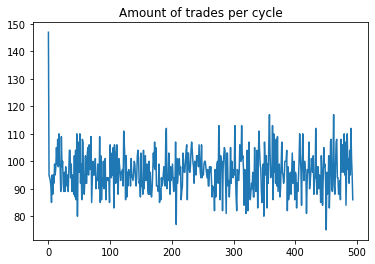

[147, 95, 94, 93, 91, 85, 95, 88, 95, 92, 99, 95, 98, 105, 99, 108, 98, 110, 99, 98, 89, 109, 98, 100, 92, 89, 96, 89, 98, 91, 95, 95, 89, 97, 104, 104, 94, 99, 89, 95, 92, 88, 102, 87, 104, 86, 110, 80, 98, 107, 96, 110, 92, 99, 86, 108, 107, 91, 88, 93, 102, 92, 92, 103, 105, 95, 106, 97, 98, 109, 85, 93, 100, 95, 99, 95, 101, 90, 94, 93, 99, 96, 90, 109, 85, 102, 86, 94, 91, 100, 90, 98, 101, 86, 94, 94, 93, 94, 93, 85, 106, 95, 94, 103, 95, 105, 83, 106, 101, 92, 102, 106, 93, 88, 101, 99, 96, 93, 96, 96, 97, 91, 111, 106, 100, 86, 102, 87, 96, 91, 97, 95, 96, 91, 101, 95, 94, 93, 96, 100, 99, 94, 91, 94, 102, 104, 101, 92, 93, 87, 103, 91, 92, 88, 104, 90, 97, 102, 93, 98, 99, 90, 88, 100, 88, 96, 89, 87, 90, 96, 103, 98, 107, 97, 105, 91, 91, 91, 89, 99, 85, 90, 86, 94, 91, 92, 95, 98, 94, 91, 107, 112, 90, 95, 93, 103, 95, 88, 98, 93, 96, 99, 93, 89, 94, 91, 107, 77, 101, 92, 95, 100, 101, 95, 98, 86, 89, 91, 103, 99, 96, 96, 100, 104, 106, 86, 103, 103, 97, 96, 98, 104, 107, 10

In [71]:
plt.plot(list(range(len(ob.trade_counts))), ob.trade_counts, label = '#Trades')
plt.title('Amount of trades per cycle')
plt.show()
print(ob.trade_counts)

In [72]:
money = []
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][3])
print(sorted(money, reverse=True))


[84, 83, 83, 83, 83, 82, 82, 81, 81, 81, 81, 81, 81, 81, 81, 80, 80, 80, 80, 80, 79, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,

Text(0, 0.5, 'Price')

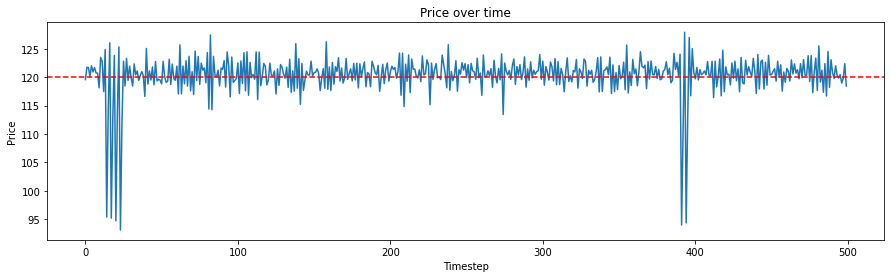

In [73]:
plt.figure().set_figwidth(15)
plt.plot(list(range(simulations)), asset_prices, label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.title("Price over time")
plt.xlabel("Timestep")
plt.ylabel("Price")

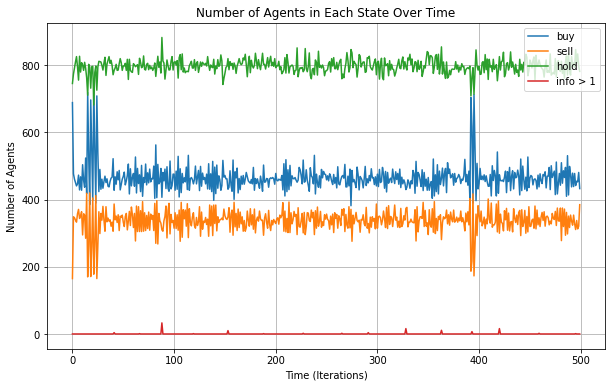

In [74]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in ob.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

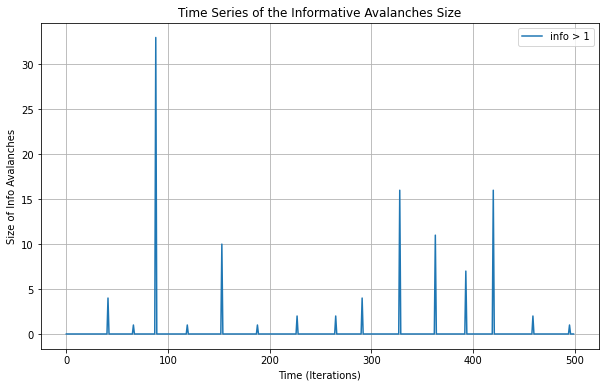

In [75]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in ob.state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Size of Info Avalanches')
plt.title('Time Series of the Informative Avalanches Size')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

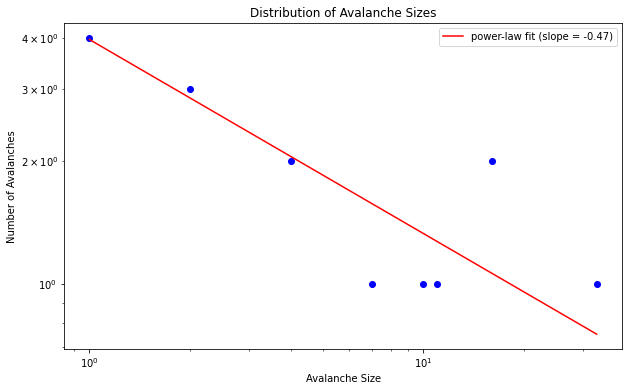

In [76]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(ob.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()